# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
#from __future__ import division, print_function, absolute_import
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import cv2
import os
import glob

# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
sizes = train['sizes']
coords = train['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Class labels:
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)
2 :  Speed limit (50km/h)
3 :  Speed limit (60km/h)
4 :  Speed limit (70km/h)
5 :  Speed limit (80km/h)
6 :  End of speed limit (80km/h)
7 :  Speed limit (100km/h)
8 :  Speed limit (120km/h)
9 :  No passing
10 :  No passing for vehicles over 3.5 metric tons
11 :  Right-of-way at the next intersection
12 :  Priority road
13 :  Yield
14 :  Stop
15 :  No vehicles
16 :  Vehicles over 3.5 metric tons prohibited
17 :  No entry
18 :  General caution
19 :  Dangerous curve to the left
20 :  Dangerous curve to the right
21 :  Double curve
22 :  Bumpy road
23 :  Slippery road
24 :  Road narrows on the right
25 :  Road work
26 :  Traffic signals
27 :  Pedestrians
28 :  Children crossing
29 :  Bicycles crossing
30 :  Beware of ice/snow
31 :  Wild animals crossing
32 :  End of all speed and passing limits
33 :  Turn right ahead
34 :  Turn left ahead
35 :  Ahead only
36 :  Go straight or right
37 :  Go straight or left
38 :  Keep right

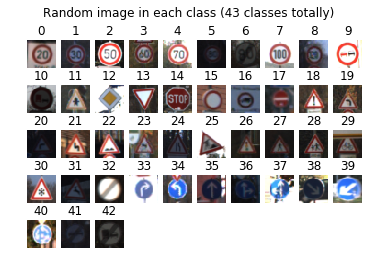

In [4]:
sign_csv = np.genfromtxt('signnames.csv', dtype=None, delimiter=',')
sign_labels = sign_csv[1:,0]
sign_names = sign_csv[1:,1]
row, column = 5, 10
fig, axs = plt.subplots(row, column)
fig.suptitle('Random image in each class (43 classes totally)')
for class_idx in range(row*column):
    if class_idx < n_classes:
        X_cur_class = X_train[y_train == class_idx]
        X_class_rand_img = X_cur_class[np.random.randint(len(X_cur_class))]
        axs[class_idx//column, class_idx%column].imshow(X_class_rand_img)
        axs[class_idx//column, class_idx%column].set_title(class_idx)
        axs[class_idx//column, class_idx%column].axis('off')
    else: axs[class_idx//column, class_idx%column].axis('off')

print('Class labels:')
for i in range(n_classes):
    print(i, ': ', sign_names[i].decode('utf-8'))


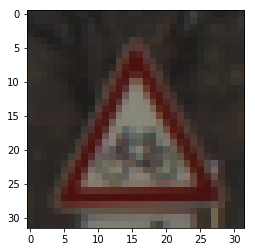

In [5]:
X_cur_class = X_train[y_train == 29]
X_class_rand_img = X_cur_class[np.random.randint(len(X_cur_class))]
plt.imshow(X_class_rand_img)

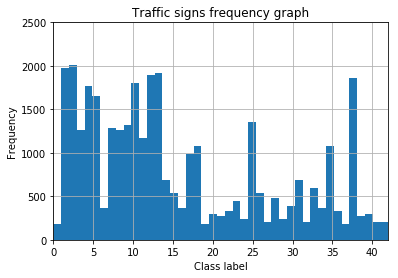

In [6]:
data_numbers = []
for class_idx in range(n_classes):
    X_cur_class = X_train[y_train == class_idx]
    for j in range(len(X_cur_class)):
        data_numbers.append(class_idx)
#print(data_numbers)

plt.figure()
n, bins, patches = plt.hist(data_numbers, 43)
plt.xlabel('Class label')
plt.ylabel('Frequency')
plt.title('Traffic signs frequency graph')
plt.xlim(0, 42)
plt.ylim(0, 2500)
plt.grid(True)
plt.savefig('../images/data_hist.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Data augmentation using deep convolutional generative adversarial networks (DCGANs) and data pre-processing

From the histogram above, we can see that the German Traffic Sign Dataset is really imbalanced. Therefore, I implement DCGANs to generate fake training data for the minority classes (below 1000 examples).

#### Find minority classes

In [7]:
### Find minority classes (below 1000 examples) ###
minority_X_train = {}
for class_idx in range(n_classes):
    X_cur_class = X_train[y_train == class_idx]
    if (len(X_cur_class)) < 1000:
        minority_X_train[class_idx] = X_cur_class

#### Image normaization for DCGANs training

In [8]:
### Image normalization ###
def img_normalization(images):
    
    img = np.zeros((len(images),32,32,3))
    i = 0
    for image in images:
        img[i,:,:,:] = np.float32(image)
        # Normalize the image to the range of [-1, 1]
        max_R = np.max(img[i,:,:,0])
        max_G = np.max(img[i,:,:,1])
        max_B = np.max(img[i,:,:,2])
        img[i,:,:,0] /= max_R
        img[i,:,:,1] /= max_G
        img[i,:,:,2] /= max_B
        img[i,:,:,0] = ((img[i,:,:,0]) - 0.5)/0.5
        img[i,:,:,1] = ((img[i,:,:,1]) - 0.5)/0.5
        img[i,:,:,2] = ((img[i,:,:,2]) - 0.5)/0.5

        i += 1
        
    return img

# Normalize the trainging image to the range of [-1, 1] for DCGANs training
# Since the fake image output from the generator is within the range of [-1, 1], 
# we have to normalize the real image also to the range of [-1, 1]
X_train_norm_GAN = {}
for minority_class in minority_X_train:
    X_train_norm_GAN[minority_class] = img_normalization(minority_X_train[minority_class])

#### Define the training and network parameters for DCGAN

In [9]:
# Training Parameters
EPOCH = 300
BATCH_SIZE = 16

# Network Parameters
noise_dim = 128 # Noise data points

In [10]:
# Generator Network
# Input: Noise (uniform distribution within [-1, 1]), Output: Fake image (within the range of [-1, 1])
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=8*8*256)
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, keep_prob)
        
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 8, 8, 256)
        x = tf.reshape(x, shape=[-1, 8, 8, 256])
        
        # Deconvolution, image shape: (batch, 8, 8, 128)
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=1, padding='SAME')
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, keep_prob)
        
        # Deconvolution, image shape: (batch, 16, 16, 64)
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='SAME')
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, keep_prob)
        
        # Deconvolution, image shape: (batch, 32, 32, 3)
        x = tf.layers.conv2d_transpose(x, 3, 5, strides=2, padding='SAME')
        
        # Apply tanh to clip values between -1 and 1
        x = tf.nn.tanh(x)
        return x

# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='SAME')
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='SAME')
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='SAME')
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, keep_prob)
        
        x = flatten(x)
        x = tf.nn.tanh(x)
        # Output 2 classes: real and fake images
        x = tf.layers.dense(x, 2)
        
    return x

### Build networks ###
# Network inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
keep_prob = tf.placeholder(tf.float32)

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from real image input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)
disc_concat = tf.concat([disc_real, disc_fake], axis=0)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Targets (real or fake images)
disc_target = tf.placeholder(tf.int32, shape=[None])
gen_target = tf.placeholder(tf.int32, shape=[None])

# Build Loss
disc_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_concat, labels=disc_target))
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=gen_target))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5, beta2=0.999)

### Training Variables for each optimizer ###
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

GAN_saver = tf.train.Saver(max_to_keep=len(X_train_norm_GAN))

#### DCGAN training

In [ ]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

def GAN_train(X_train, class_idx):
    print('training class' + str(class_idx) + '...')
    num_examples = len(X_train)
    
    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for i in range(EPOCH):
            X_train = shuffle(X_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x = X_train[offset:offset+BATCH_SIZE]
                batch_x_size = batch_x.shape[0]
                
                # Generate normal distribution for the input of generator
                z = np.random.normal(0., 1., size=[batch_x_size, noise_dim])

                # The first half of data fed to the discriminator are real images, thus targets are 1 (real image).
                # The other half are fake images from the generator, thus targets are 0 (fake image).
                batch_disc_y = np.concatenate(
                    [np.ones([batch_x_size]), np.zeros([batch_x_size])], axis=0)
                # Generator tries to fool the discriminator, thus targets are 1.
                batch_gen_y = np.ones([batch_x_size])

                # Training
                feed_dict = {real_image_input: batch_x, noise_input: z,
                             disc_target: batch_disc_y, gen_target: batch_gen_y,
                             keep_prob: 0.8}
                _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                        feed_dict=feed_dict)
            #print(i)
            #print('EPOCH %i: Generator Loss: %f, Discriminator Loss: %f' % (i + 1, gl, dl))
            #if ((i + 1) % 10 == 0):
            #print(i)
        GAN_saver.save(sess, '../GANmodel/DCGAN_' + str(class_idx) +'.ckpt')
            
        print('Model Saved')
        
for minority_class in X_train_norm_GAN:
    GAN_train(X_train_norm_GAN[minority_class], minority_class)

#### Visualization of the fake data

INFO:tensorflow:Restoring parameters from ../GANmodel/DCGAN_0.ckpt
INFO:tensorflow:Restoring parameters from ../GANmodel/DCGAN_6.ckpt
INFO:tensorflow:Restoring parameters from ../GANmodel/DCGAN_14.ckpt
INFO:tensorflow:Restoring parameters from ../GANmodel/DCGAN_30.ckpt
INFO:tensorflow:Restoring parameters from ../GANmodel/DCGAN_37.ckpt


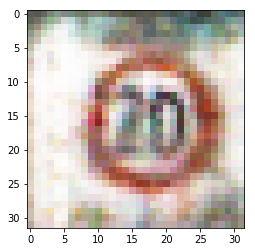

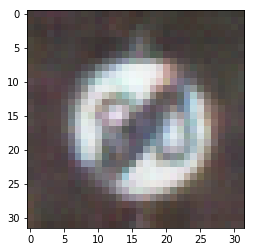

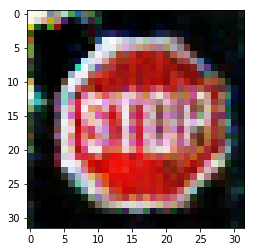

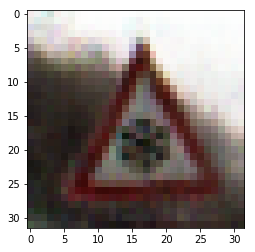

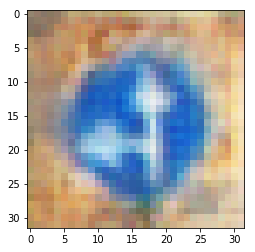

In [11]:
# testing the GAN model
def GAN_visualization(class_idx):

    with tf.Session() as sess:

        # restore saved session with highest validation accuracy
        GAN_saver.restore(sess, '../GANmodel/DCGAN_' + str(class_idx) + '.ckpt')
        z = np.random.normal(0., 1., size=[1,noise_dim])
        g = sess.run(gen_sample, feed_dict={noise_input: z, keep_prob: 0.9})
        yuv_img = cv2.cvtColor(g[0], cv2.COLOR_RGB2YUV)
        g = (g/2 + 0.5)
        
        #yuv_img_pre = preprocess_image_YUV(g)
        #print(yuv_img_pre)
        #plt.figure()
        #plt.imshow(yuv_img_pre[0,:,:,0], cmap='gray')
        #plt.figure()
        
        #plt.imshow(yuv_img[:,:,0], cmap='gray')
        
        plt.figure()
        plt.imshow(g[0])
        mpimg.imsave('../images/DCGAN_fake_image' + str(class_idx) + '.jpg', g[0])
        #print(g[0])

GAN_visualization(0)
GAN_visualization(6)
GAN_visualization(14)
GAN_visualization(30)
GAN_visualization(37)
#for class_idx in minority_X_train:
#    GAN_visualization(class_idx)

#### Adding fake images to the train set

In [12]:
# Normalize the training set to the range of [-1, 1] before adding fake data 
# so that all the traing dataset will be in the same range. Also do this to validation and test datasets.
X_train_norm = img_normalization(X_train)
X_valid_norm = img_normalization(X_valid)
X_test_norm = img_normalization(X_test)

In [ ]:
### Generate fake data to the training dataset ###
def augment_fake_data(X_data, y_data, class_idx, num_of_fake_data):
    with tf.Session() as sess:

        # restore saved session with highest validation accuracy
        GAN_saver.restore(sess, '../GANmodel/DCGAN_' + str(class_idx) +'.ckpt')
        for i in range(num_of_fake_data):
            #var = np.random.uniform(0.2, 1.8)
            z = np.random.normal(0., 1., size=[1,noise_dim])
            fake_data = sess.run(gen_sample, feed_dict={noise_input: z, keep_prob: 0.9})
            X_data = np.append(X_data, fake_data, axis=0)
            y_data = np.append(y_data, class_idx)
            
    return X_data, y_data

X_train_aug = X_train_norm
y_train_aug = y_train
print('Number of original train examples = ' + str(X_train_aug.shape[0]))
# Adding fake data
for minority_class in minority_X_train:
    num_of_fake_data = 1000 - len(minority_X_train[minority_class])
    print('Number of augmented images for class' + str(minority_class) + ' is ' + str(num_of_fake_data))
    X_train_aug, y_train_aug = augment_fake_data(X_train_aug, y_train_aug, minority_class, num_of_fake_data)
    
print('Number of augmented train examples = ' + str(X_train_aug.shape[0]))
np.save("../augmented_train_set/augmented_train_set_X.npy", X_train_aug)
np.save("../augmented_train_set/augmented_train_set_y.npy", y_train_aug)

In [27]:
# Reload the augmented data
X_train_aug = np.load("../augmented_train_set/augmented_train_set_X.npy")
y_train_aug = np.load("../augmented_train_set/augmented_train_set_y.npy")
print(X_train_aug.shape)

(51690, 32, 32, 3)


#### Data pre-processing

In [28]:
def preprocess_image_YUV(images):
    """
    Convert the images from RGB to YUV color space
    Adjust image to have larger contrast
    Normalize and standardize the data to have zero mean and unit variance in each channel
    """
    
    # Convert images to range of 0-255 (cv2.equalizeHist works with this range)
    images = (images/2 + 0.5)*255
    images = np.uint8(images)
    
    # convert images from RGB to YUV color space
    y_images = np.array([np.expand_dims(cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for image in images])

    # adjust image contrast
    y_images = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(image)), 2) for image in y_images])
    
    y_images = np.float32(y_images)
    # Standardization
    if (len(y_images) == 1):
        y_images -= np.mean(y_images)
        y_images /= np.std(y_images)
    else:
        y_images -= np.mean(y_images, axis=0)
        y_images /= np.std(y_images, axis=0)

    return y_images

In [29]:
# Pre-process the augmented training dataset as well as the validation and test datasets
# For the training set, I use the augmented one.
X_train_norm_Y = preprocess_image_YUV(X_train_aug)
#X_train_norm_Y = preprocess_image_YUV(X_train_norm)
X_valid_norm_Y = preprocess_image_YUV(X_valid_norm)
X_test_norm_Y = preprocess_image_YUV(X_test_norm)

#### Visualization of preprocessed data

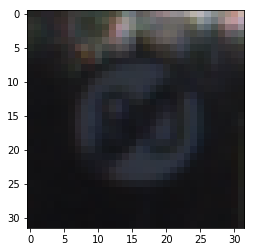

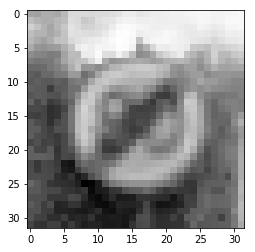

In [26]:
# Visualization of preprocessed image and original image
X_class = X_train[y_train == 6]
rand_idx = np.random.randint(len(X_class))
rand_original_img = X_class[rand_idx]
plt.figure()
plt.imshow(rand_original_img)
mpimg.imsave('../images/original_image.jpg', rand_original_img)

X_class_norm = X_train_norm_Y[y_train == 6]
rand_norm_img = X_class_norm[rand_idx]
plt.figure()
plt.imshow(rand_norm_img[:,:,0], cmap='gray')
mpimg.imsave('../images/preprocessed_image.jpg', rand_norm_img[:,:,0], cmap='gray')

### LeNet-5 Model Architecture

In [30]:
def LeNet(x, layer1_features=6, layer2_features=16, channel=3, two_stage=False):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x[depth].
    conv_w1 = tf.Variable(tf.random_normal([5,5,channel,layer1_features], mean=mu, stddev=sigma))
    conv_b1 = tf.Variable(tf.random_normal([layer1_features], mean=mu, stddev=sigma))
    conv1 = tf.nn.conv2d(x, conv_w1, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, conv_b1)
    # Activation.
    conv1 = tf.nn.relu(conv1) 
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)
    # Pooling. Input = 28x28x[depth]. Output = 14x14x[depth].
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv_w2 = tf.Variable(tf.random_normal([5,5,layer1_features,layer2_features], mean=mu, stddev=sigma))
    conv_b2 = tf.Variable(tf.random_normal([layer2_features], mean=mu, stddev=sigma))
    conv2 = tf.nn.conv2d(conv1, conv_w2, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, conv_b2)
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)
    # Pooling. Input = 10x10x[depth]. Output = 5x5x[depth].
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    if two_stage:
        # Flatten. Input = 5x5x[depth]. Output = 400.
        fc0_1 = flatten(conv1) 
        fc0_2 = flatten(conv2) 
        fc0 = tf.concat([fc0_1, fc0_2], axis=1)
        total_neurons = 14*14*layer1_features + 5*5*layer2_features
    else:
        fc0 = flatten(conv2) 
        total_neurons = 5*5*layer2_features
    
    # Layer 3: Fully Connected. Output = 120.
    fc_w1 = tf.Variable(tf.random_normal([total_neurons,120], mean=mu, stddev=sigma))
    fc_b1 = tf.Variable(tf.random_normal([120], mean=mu, stddev=sigma))
    fc1 = tf.add(tf.matmul(fc0, fc_w1), fc_b1)
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    if not two_stage:
        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc_w2 = tf.Variable(tf.random_normal([120,84], mean=mu, stddev=sigma))
        fc_b2 = tf.Variable(tf.random_normal([84], mean=mu, stddev=sigma))
        fc2 = tf.add(tf.matmul(fc1, fc_w2), fc_b2)
        # Activation.
        fc2 = tf.nn.relu(fc2)
        # Dropout
        fc2 = tf.nn.dropout(fc2, keep_prob)

        # Layer 5: Fully Connected. Input = 84. Output = 43.
        fc_w3 = tf.Variable(tf.random_normal([84,43], mean=mu, stddev=sigma))
        fc_b3 = tf.Variable(tf.random_normal([43], mean=mu, stddev=sigma))
        fc3 = tf.add(tf.matmul(fc2, fc_w3), fc_b3)
        logits = fc3
    else:
        # Layer 5: Fully Connected. Input = 120. Output = 43.
        fc_w2 = tf.Variable(tf.random_normal([120,43], mean=mu, stddev=sigma))
        fc_b2 = tf.Variable(tf.random_normal([43], mean=mu, stddev=sigma))
        fc2 = tf.add(tf.matmul(fc1, fc_w2), fc_b2)
        logits = fc2   
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Training pipeline

In [31]:
# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [32]:
rate = 0.001

def training_pipeline(lr, logits):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    training_operation = optimizer.minimize(loss_operation)
    
    return training_operation
    
logits_baseline = LeNet(x, layer1_features=6, layer2_features=16, channel=1, two_stage=False)
logits_one_stage_38_64 = LeNet(x, layer1_features=38, layer2_features=64, channel=1, two_stage=False)
logits_two_stage_38_64 = LeNet(x, layer1_features=38, layer2_features=64, channel=1, two_stage=True)

training_baseline = training_pipeline(rate, logits_baseline)
training_one_stage_38_64 = training_pipeline(rate, logits_one_stage_38_64)
training_two_stage_38_64 = training_pipeline(rate, logits_two_stage_38_64)

#### Model evaluation

In [33]:
def accuracy(logits):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy_operation

def evaluate(X_data, y_data, accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

accuracy_baseline = accuracy(logits_baseline)
accuracy_one_stage_38_64 = accuracy(logits_one_stage_38_64)
accuracy_two_stage_38_64 = accuracy(logits_two_stage_38_64)

num_models = 5
saver = tf.train.Saver(max_to_keep=num_models*4)

#### Train the model

In [35]:
EPOCHS = 30
BATCH_SIZE = 128

def train(model_name, training_operation, accuracy_operation, X_train, X_valid, y_train, y_valid):        
    with tf.Session() as sess:
        num_examples = len(X_train)

        print("Training...")
        validation_accuracy_sum = 0

        for j in range(num_models):
            sess.run(tf.global_variables_initializer())
            for i in range(EPOCHS):
                X_train, y_train = shuffle(X_train, y_train)
                for offset in range(0, num_examples, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})
                
                train_accuracy = evaluate(X_train, y_train, accuracy_operation)
                validation_accuracy = evaluate(X_valid, y_valid, accuracy_operation)
                
                if ((i + 1) % 5 == 0):
                    print("EPOCH {} ...".format(i+1))            
                    print(model_name + ": Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}".format(train_accuracy, validation_accuracy))

            validation_accuracy_sum += validation_accuracy

            saver.save(sess, '../model/' + model_name + str(j) + '.ckpt')
            print("Model saved")

        avg_validation_accuracy = validation_accuracy_sum / num_models
        
    return avg_validation_accuracy

baseline_accuracy = train('baselineY', 
                          training_baseline, 
                          accuracy_baseline, 
                          X_train_norm_Y, 
                          X_valid_norm_Y, 
                          y_train_aug, y_valid)

one_stage_38_64_accuracy = train('one_stage_38_64Y', 
                                 training_one_stage_38_64, 
                                 accuracy_one_stage_38_64, 
                                 X_train_norm_Y, 
                                 X_valid_norm_Y, 
                                 y_train_aug, y_valid)

two_stage_38_64_accuracy = train('two_stage_38_64Y', 
                                 training_two_stage_38_64, 
                                 accuracy_two_stage_38_64, 
                                 X_train_norm_Y, 
                                 X_valid_norm_Y, 
                                 y_train_aug, y_valid)

Training...
EPOCH 5 ...
baselineY: Train Accuracy = 0.949 - Validation Accuracy: 0.879
EPOCH 10 ...
baselineY: Train Accuracy = 0.974 - Validation Accuracy: 0.931
EPOCH 15 ...
baselineY: Train Accuracy = 0.979 - Validation Accuracy: 0.929
EPOCH 20 ...
baselineY: Train Accuracy = 0.988 - Validation Accuracy: 0.940
EPOCH 25 ...
baselineY: Train Accuracy = 0.989 - Validation Accuracy: 0.936
EPOCH 30 ...
baselineY: Train Accuracy = 0.989 - Validation Accuracy: 0.945
Model saved
EPOCH 5 ...
baselineY: Train Accuracy = 0.947 - Validation Accuracy: 0.884
EPOCH 10 ...
baselineY: Train Accuracy = 0.971 - Validation Accuracy: 0.908
EPOCH 15 ...
baselineY: Train Accuracy = 0.984 - Validation Accuracy: 0.929
EPOCH 20 ...
baselineY: Train Accuracy = 0.986 - Validation Accuracy: 0.934
EPOCH 25 ...
baselineY: Train Accuracy = 0.987 - Validation Accuracy: 0.926
EPOCH 30 ...
baselineY: Train Accuracy = 0.988 - Validation Accuracy: 0.946
Model saved
EPOCH 5 ...
baselineY: Train Accuracy = 0.931 - Valida

#### Boosting

In [36]:
def softmax(prediction, n_classes):
    prediction_exp = np.exp(prediction, dtype=np.float64)
    prediction_exp_sum = np.sum(prediction_exp, axis=1)
    softmax = np.zeros((len(prediction), n_classes))
    for i in range(len(prediction)):
        softmax[i] = prediction_exp[i]/prediction_exp_sum[i]
        
    return softmax
    
def boosting_evaluate(model_name, logits, X_data, y_data, show_prediction=False, show_top_k=False):
    num_examples = len(X_data)
    accuracy_sum = 0
    
    with tf.Session() as sess:
        # Restore variables from disk.
        boosted_prediction = np.zeros((num_examples, 43))
        for i in range(num_models):
            saver.restore(sess, '../model/' + model_name + str(i) + '.ckpt')
            
            single_output = logits.eval(feed_dict={x: X_data, keep_prob: 1.0})
            single_accuracy = np.sum(np.equal(np.argmax(single_output, axis=1), y_data))/num_examples
            accuracy_sum += single_accuracy
            
            # Softmax
            single_softmax = softmax(single_output, 43)
            boosted_prediction += single_softmax

        boosted_prediction_sum = np.sum(boosted_prediction, axis=1)
        boosted_prediction_prob = np.zeros((num_examples, 43))
        for i in range(len(boosted_prediction)):
            boosted_prediction_prob[i] = boosted_prediction[i]/boosted_prediction_sum[i]
        
        correct_prediction = np.sum(np.equal(np.argmax(boosted_prediction_prob, axis=1), y_data))
        avg_accuracy = accuracy_sum/num_models
        final_accuracy = correct_prediction/num_examples

        if show_prediction:
            print('Predicted label: ' + str(np.argmax(boosted_prediction_prob, axis=1)))
            print('True label: ' + str(y_data))
            
        if show_top_k:
            for i in range(num_examples):
                print('Top 5 prediction for image' + str(i + 1) + ' is: (True label is ' + str(y_data[i]) + ')')
                top5 = sess.run(tf.nn.top_k(tf.constant(boosted_prediction_prob[i,:]), k=5))
                print('- Prediction = ' + str(top5[1][0]) + ' has the probability of {:.1f}%'.format(100*top5[0][0]))
                print('- Prediction = ' + str(top5[1][1]) + ' has the probability of {:.1f}%'.format(100*top5[0][1]))
                print('- Prediction = ' + str(top5[1][2]) + ' has the probability of {:.1f}%'.format(100*top5[0][2]))
                print('- Prediction = ' + str(top5[1][3]) + ' has the probability of {:.1f}%'.format(100*top5[0][3]))
                print('- Prediction = ' + str(top5[1][4]) + ' has the probability of {:.1f}%'.format(100*top5[0][4]))
        #print(np.sum(np.equal(np.argmax(boosted_prediction, axis=1), y_data)))
        #print(len(y_data))
        #print('Accuracy: {:.1f}%'.format(100*final_accuracy))
        return avg_accuracy, final_accuracy
    


#### Training accuracy

In [37]:
X_train_norm_Y = preprocess_image_YUV(X_train_norm)
baseline_avg_accuracy, baseline_boosting_accuracy = boosting_evaluate('baselineY', logits_baseline, X_train_norm_Y, y_train)
one_stage_38_64_avg_accuracy, one_stage_38_64_boosting_accuracy = boosting_evaluate('one_stage_38_64Y', logits_one_stage_38_64, X_train_norm_Y, y_train)
two_stage_38_64_avg_accuracy, two_stage_38_64_boosting_accuracy = boosting_evaluate('two_stage_38_64Y', logits_two_stage_38_64, X_train_norm_Y, y_train)
print('Original LeNet-5 architecture:')
print('- Training accuracy without boosting: {:.1f}%, Training accuracy with boosting: {:.1f}%'.format(100*baseline_avg_accuracy, 100*baseline_boosting_accuracy))
print()
print('Modified LeNet-5 architecture:')
print('- Training accuracy without boosting: {:.1f}%, Training accuracy with boosting: {:.1f}%'.format(100*one_stage_38_64_avg_accuracy, 100*one_stage_38_64_boosting_accuracy))
print()
print('Two-stage architecture:')
print('- Training accuracy without boosting: {:.1f}%, Training accuracy with boosting: {:.1f}%'.format(100*two_stage_38_64_avg_accuracy, 100*two_stage_38_64_boosting_accuracy))


INFO:tensorflow:Restoring parameters from ../model/baselineY0.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY0.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY1.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY1.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY2.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY2.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY3.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY3.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY4.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y4.ckpt


Original LeNet-5 architecture:
- Training accuracy without boosting: 98.1%, Training accuracy with boosting: 99.2%

Modified LeNet-5 architecture:
- Training accuracy without boosting: 99.7%, Training accuracy with boosting: 99.9%

Two-stage architecture:
- Training accuracy without boosting: 99.9%, Training accuracy with boosting: 100.0%


#### Validation accuracy

In [38]:
baseline_avg_accuracy, baseline_boosting_accuracy = boosting_evaluate('baselineY', logits_baseline, X_valid_norm_Y, y_valid)
one_stage_38_64_avg_accuracy, one_stage_38_64_boosting_accuracy = boosting_evaluate('one_stage_38_64Y', logits_one_stage_38_64, X_valid_norm_Y, y_valid)
two_stage_38_64_avg_accuracy, two_stage_38_64_boosting_accuracy = boosting_evaluate('two_stage_38_64Y', logits_two_stage_38_64, X_valid_norm_Y, y_valid)

print('Original LeNet-5 architecture:')
print('- Validation accuracy without boosting: {:.1f}%, Validation accuracy with boosting: {:.1f}%'.format(100*baseline_avg_accuracy, 100*baseline_boosting_accuracy))
print()
print('Modified LeNet-5 architecture:')
print('- Validation accuracy without boosting: {:.1f}%, Validation accuracy with boosting: {:.1f}%'.format(100*one_stage_38_64_avg_accuracy, 100*one_stage_38_64_boosting_accuracy))
print()
print('Two-stage architecture:')
print('- Validation accuracy without boosting: {:.1f}%, Validation accuracy with boosting: {:.1f}%'.format(100*two_stage_38_64_avg_accuracy, 100*two_stage_38_64_boosting_accuracy))


INFO:tensorflow:Restoring parameters from ../model/baselineY0.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY0.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY1.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY1.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY2.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY2.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY3.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY3.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY4.ckpt


INFO:tensorflow:Restoring parameters from ../model/baselineY4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/two_stage_38_64Y4.ckpt


Original LeNet-5 architecture:
- Validation accuracy without boosting: 94.2%, Validation accuracy with boosting: 96.4%

Modified LeNet-5 architecture:
- Validation accuracy without boosting: 96.7%, Validation accuracy with boosting: 97.8%

Two-stage architecture:
- Validation accuracy without boosting: 94.8%, Validation accuracy with boosting: 96.3%


#### Test accuracy
From the validation accuracy above, I chose the modified LeNet-5 model as the final model for testing

In [62]:
one_stage_38_64_avg_accuracy, one_stage_38_64_boosting_accuracy = boosting_evaluate('one_stage_38_64Y', logits_one_stage_38_64, X_test_norm_Y, y_test)
print('- Testing accuracy of final model: {:.1f}%'.format(100*one_stage_38_64_boosting_accuracy))


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


- Testing accuracy of final model: 96.5%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

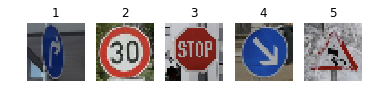

In [63]:
import glob

new_test_imgs_dir = 'new_test_images'
new_test_imgs = glob.glob(os.path.join(new_test_imgs_dir, 'test*.png'))
new_test_imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in new_test_imgs]
new_test_imgs = [cv2.resize(f, (32,32)) for f in new_test_imgs]

new_imgs_labels = [33, 1, 14, 38, 23]
column = len(new_test_imgs)
fig, axs = plt.subplots(1, column)
for i in range(column):
    axs[i%column].imshow(new_test_imgs[i])
    axs[i%column].set_title(i + 1)
    axs[i%column].axis('off')
plt.savefig('../images/new_test_images.png')

### Predict the Sign Type for Each Image

In [65]:
new_test_images_norm = img_normalization(new_test_imgs)
new_test_images_norm = preprocess_image_YUV(new_test_images_norm)
num_models = 5
one_stage_38_64_avg_accuracy, one_stage_38_64_boosting_accuracy = boosting_evaluate('one_stage_38_64Y', 
                                                                                    logits_one_stage_38_64, 
                                                                                    new_test_images_norm, 
                                                                                    new_imgs_labels,
                                                                                    show_prediction=True,
                                                                                    show_top_k=False)
print('Accuracy: {:.1f}%'.format(100*one_stage_38_64_boosting_accuracy))

INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


Predicted label: [ 2  1 14 38  5]
True label: [33, 1, 14, 38, 23]
Accuracy: 60.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [66]:
one_stage_38_64_avg_accuracy, one_stage_38_64_boosting_accuracy = boosting_evaluate('one_stage_38_64Y', 
                                                                                    logits_one_stage_38_64, 
                                                                                    new_test_images_norm, 
                                                                                    new_imgs_labels,
                                                                                    show_prediction=False,
                                                                                    show_top_k=True)

INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y0.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y1.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y2.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y3.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


INFO:tensorflow:Restoring parameters from ../model/one_stage_38_64Y4.ckpt


Top 5 prediction for image1 is: (True label is 33)
- Prediction = 2 has the probability of 12.1%
- Prediction = 28 has the probability of 8.9%
- Prediction = 5 has the probability of 8.0%
- Prediction = 30 has the probability of 6.1%
- Prediction = 11 has the probability of 5.7%
Top 5 prediction for image2 is: (True label is 1)
- Prediction = 1 has the probability of 38.1%
- Prediction = 0 has the probability of 22.0%
- Prediction = 5 has the probability of 14.9%
- Prediction = 4 has the probability of 6.8%
- Prediction = 8 has the probability of 5.7%
Top 5 prediction for image3 is: (True label is 14)
- Prediction = 14 has the probability of 40.7%
- Prediction = 8 has the probability of 10.1%
- Prediction = 5 has the probability of 4.1%
- Prediction = 3 has the probability of 3.4%
- Prediction = 15 has the probability of 2.9%
Top 5 prediction for image4 is: (True label is 38)
- Prediction = 38 has the probability of 99.8%
- Prediction = 34 has the probability of 0.1%
- Prediction = 15 